# Importando librerías

In [ ]:
import pandas as pd
import numpy as np
# Valores faltantes
import missingno as msno
# Atípicos
import matplotlib.pyplot as plt
import seaborn as sns

from rich.console import Console
from rich.table import Table
from rich.panel import Panel
from rich.prompt import Prompt

from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

import category_encoders as ce




# Importando la base de datos

In [9]:
df = pd.read_csv('./db/hotel_bookings_limpio.csv', encoding='ISO-8859-1')

# Diseño de modelo

##### 1. ¿Este es un problema de regresión o clasificación?

Este es un problema de clasificación. La tarea es predecir si una reserva será cancelada o no, lo cual es una variable categórica (is_canceled).

##### 2. Hacer tabla de correlación para las variables

In [10]:
# Seleccionar las columnas numéricas
columnas_numericas = df.select_dtypes(include=['number']).columns

# Imprimir los nombres de las columnas numéricas
print(columnas_numericas)

Index(['is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests'],
      dtype='object')


In [12]:
# Calcular la matriz de correlaciones
matriz_correlaciones = df[columnas_numericas].corr()

# Crear la consola de Rich
console = Console()

# Crear la tabla con título
table = Table(title="Matriz de Correlaciones")

# Añadir la primera columna (nombres de las columnas numéricas)
table.add_column("Columnas", justify="left", style="cyan", no_wrap=True)

# Añadir las columnas de correlaciones
for column in matriz_correlaciones.columns:
    table.add_column(column, justify="center", style="magenta")

# Añadir las filas con los valores de correlación
for idx, row in matriz_correlaciones.iterrows():
    table.add_row(
        idx,  # Nombre de la fila
        *[f"{value:.2f}" for value in row]  # Valores formateados
    )

# Imprimir la tabla
console.print(table)

                                              Matriz de Correlaciones                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━┳━━━━┳━━━┳━━━━┳━━━┳━━━━┳━━━┳━━━━┳━━━┳━━━━┳━━━┳━━━━┳━━━┳━━━━┳━━━┳━━━━┳━━━┳━━━━┓
┃ Columnas                       ┃ … ┃ l… ┃ … ┃ a… ┃ … ┃ s… ┃ … ┃ a… ┃ … ┃ b… ┃ … ┃ p… ┃ … ┃ b… ┃ … ┃ a… ┃ … ┃ t… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━╇━━━━╇━━━╇━━━━╇━━━╇━━━━╇━━━╇━━━━╇━━━╇━━━━╇━━━╇━━━━╇━━━╇━━━━╇━━━╇━━━━╇━━━╇━━━━┩
│ is_canceled                    │ … │ 0… │ … │ 0… │ … │ 0… │ … │ 0… │ … │ -… │ … │ 0… │ … │ -… │ … │ 0… │ … │ -… │
│ lead_time                      │ … │ 1… │ … │ 0… │ … │ 0… │ … │ 0… │ … │ -… │ … │ 0… │ … │ 0… │ … │ 0… │ … │ 0… │
│ arrival_date_year              │ … │ 0… │ … │ -… │ … │ 0… │ … │ 0… │ … │ -… │ … │ -… │ … │ 0… │ … │ 0… │ … │ 0… │
│ arrival_date_week_number       │ … │ 0… │ … │ 1… │ … │ 0… │ … │ 0… │ … │ 0… │ … │ 0… │ … │ 0… │ … │ 0… │ … │ 0… │
│ arrival_date_day_of_month      │ … │ 0… │ … │ 0… │ … │ -… │ … │ -… │ … │ -… │ … │ -… │ … │ 0… │ … │ 0… │ … │ -… │
│ stays_in_weekend_nights        │ … │ 0… │ … │ 0… │ … │ 1… │ … │ 0… │ … │ 0… │ … │ -… │ … │ 0… │ … │ 0… │ … │ 0… │
│ stays_in_week_nights           │ … │ 0… │ … │ 0… │ … │ 0… │ … │ 0… │ … │ 0… │ … │ -… │ … │ 0… │ … │ 0… │ … │ 0… │
│ adults                         │ … │ 0… │ … │ 0… │ … │ 0… │ … │ 1… │ … │ 0… │ … │ -… │ … │ -… │ … │ 0… │ … │ 0… │
│ children                       │ … │ 0… │ … │ 0… │ … │ 0… │ … │ 0… │ … │ 0… │ … │ -… │ … │ 0… │ … │ 0… │ … │ 0… │
│ babies                         │ … │ -… │ … │ 0… │ … │ 0… │ … │ 0… │ … │ 1… │ … │ -… │ … │ 0… │ … │ 0… │ … │ 0… │
│ is_repeated_guest              │ … │ -… │ … │ -… │ … │ -… │ … │ -… │ … │ -… │ … │ 0… │ … │ 0… │ … │ -… │ … │ -… │
│ previous_cancellations         │ … │ 0… │ … │ 0… │ … │ -… │ … │ -… │ … │ -… │ … │ 1… │ … │ -… │ … │ -… │ … │ 0… │
│ previous_bookings_not_canceled │ … │ -… │ … │ -… │ … │ -… │ … │ -… │ … │ -… │ … │ 0… │ … │ 0… │ … │ -… │ … │ 0… │
│ booking_changes                │ … │ 0… │ … │ 0… │ … │ 0… │ … │ -… │ … │ 0… │ … │ -… │ … │ 1… │ … │ 0… │ … │ 0… │
│ days_in_waiting_list           │ … │ 0… │ … │ 0… │ … │ -… │ … │ -… │ … │ -… │ … │ 0… │ … │ 0… │ … │ -… │ … │ -… │
│ adr                            │ … │ 0… │ … │ 0… │ … │ 0… │ … │ 0… │ … │ 0… │ … │ -… │ … │ 0… │ … │ 1… │ … │ 0… │
│ required_car_parking_spaces    │ … │ -… │ … │ 0… │ … │ -… │ … │ 0… │ … │ 0… │ … │ -… │ … │ 0… │ … │ 0… │ … │ 0… │
│ total_of_special_requests      │ … │ 0… │ … │ 0… │ … │ 0… │ … │ 0… │ … │ 0… │ … │ 0… │ … │ 0… │ … │ 0… │ … │ 1… │
└────────────────────────────────┴───┴────┴───┴────┴───┴────┴───┴────┴───┴────┴───┴────┴───┴────┴───┴────┴───┴────┘

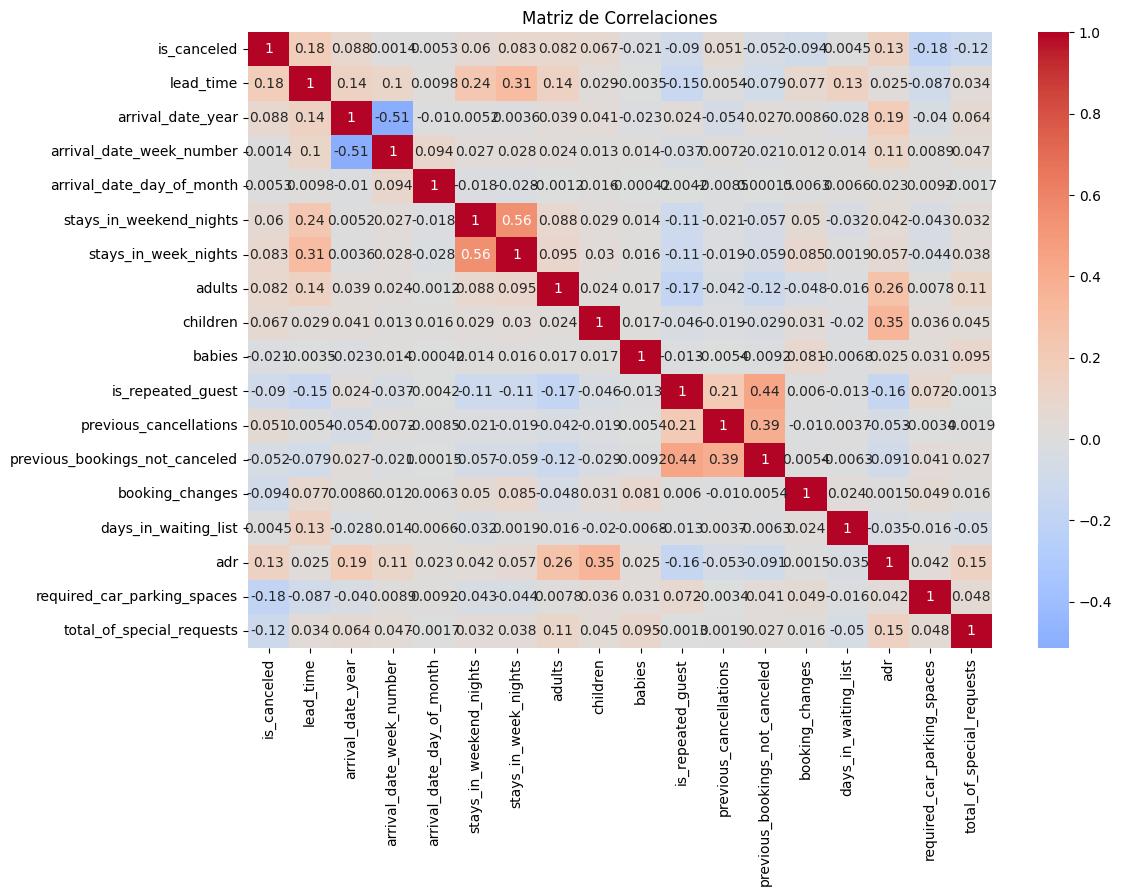

In [13]:
# Crear un mapa de calor de la matriz de correlaciones
plt.figure(figsize=(12, 8))
sns.heatmap(matriz_correlaciones, annot=True, cmap='coolwarm', center=0)

# Añadir título
plt.title('Matriz de Correlaciones')

# Mostrar el mapa de calor
plt.show()

##### 3. Encontrar las mejores variables para predecir cancelaciones

In [14]:
# Seleccionar las mejores variables
X = df[columnas_numericas]
y = df['is_canceled']

# Aplicar SelectKBest
selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X, y)

# Obtener los nombres de las variables seleccionadas
mask = selector.get_support()  # lista de booleanos
new_features = []  # La lista de las mejores características

for bool, feature in zip(mask, columnas_numericas):
    if bool:
        new_features.append(feature)

print(f"Las mejores variables para predecir cancelaciones son: {new_features}")

Las mejores variables para predecir cancelaciones son: ['is_canceled', 'lead_time', 'arrival_date_year', 'stays_in_week_nights', 'adults', 'is_repeated_guest', 'booking_changes', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']


c:\Users\ASUS\OneDrive\Documentos\1aaaaEsposo_Jaime\U_Trabajo\perfilPython\mi_entorno\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


##### 4. ¿Cuál es el modelo con mayor performance?

In [15]:
# Crear una consola Rich
console = Console()


# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X[new_features], y, test_size=0.2, random_state=42)


# Inicializar tabla para los resultados
result_table = Table(title="Resultados de Modelos", show_lines=True)
result_table.add_column("Modelo", justify="left", style="bright_cyan")
result_table.add_column("Precisión", justify="center", style="bright_green")
result_table.add_column("Reporte de Clasificación", justify="left", style="bright_magenta")




# Entrenar y evaluar el Árbol de Decisión
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_report = classification_report(y_test, y_pred_dt, output_dict=False)

# Añadir los resultados a la tabla
result_table.add_row(
    "Árbol de Decisión",
    f"{dt_accuracy:.2f}",
    f"[bold bright_magenta]{classification_report(y_test, y_pred_dt)}[/bold bright_magenta]"
)




# Entrenar y evaluar el Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_report = classification_report(y_test, y_pred_rf, output_dict=False)

# Añadir los resultados a la tabla
result_table.add_row(
    "Random Forest",
    f"{rf_accuracy:.2f}",
    f"[bold bright_magenta]{classification_report(y_test, y_pred_rf)}[/bold bright_magenta]"
)






# Entrenar y evaluar la Regresión Logística
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_report = classification_report(y_test, y_pred_lr, output_dict=False)

# Añadir los resultados a la tabla
result_table.add_row(
    "Regresión Logística",
    f"{lr_accuracy:.2f}",
    f"[bold bright_magenta]{classification_report(y_test, y_pred_lr)}[/bold bright_magenta]"
)





# Determinar el modelo con mejor precisión
best_model = max(
    [("Árbol de Decisión", dt_accuracy), 
     ("Random Forest", rf_accuracy), 
     ("Regresión Logística", lr_accuracy)], 
    key=lambda x: x[1]
)

# Imprimir resultados
console.print(result_table)
console.print(f"[bold yellow]El modelo con mayor performance es: {best_model[0]} con una precisión de {best_model[1]:.2f}[/bold yellow]")


                                   Resultados de Modelos                                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Modelo              ┃ Precisión ┃ Reporte de Clasificación                              ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Árbol de Decisión   │   1.00    │               precision    recall  f1-score   support │
│                     │           │                                                       │
│                     │           │            0       1.00      1.00      1.00     12676 │
│                     │           │            1       1.00      1.00      1.00      4798 │
│                     │           │                                                       │
│                     │           │     accuracy                           1.00     17474 │
│                     │           │    macro avg       1.00      1.00      1.00     17474 │
│                     │           │ weighted avg       1.00      1.00      1.00     17474 │
│                     │           │                                                       │
├─────────────────────┼───────────┼───────────────────────────────────────────────────────┤
│ Random Forest       │   1.00    │               precision    recall  f1-score   support │
│                     │           │                                                       │
│                     │           │            0       1.00      1.00      1.00     12676 │
│                     │           │            1       1.00      1.00      1.00      4798 │
│                     │           │                                                       │
│                     │           │     accuracy                           1.00     17474 │
│                     │           │    macro avg       1.00      1.00      1.00     17474 │
│                     │           │ weighted avg       1.00      1.00      1.00     17474 │
│                     │           │                                                       │
├─────────────────────┼───────────┼───────────────────────────────────────────────────────┤
│ Regresión Logística │   1.00    │               precision    recall  f1-score   support │
│                     │           │                                                       │
│                     │           │            0       1.00      1.00      1.00     12676 │
│                     │           │            1       1.00      1.00      1.00      4798 │
│                     │           │                                                       │
│                     │           │     accuracy                           1.00     17474 │
│                     │           │    macro avg       1.00      1.00      1.00     17474 │
│                     │           │ weighted avg       1.00      1.00      1.00     17474 │
│                     │           │                                                       │
└─────────────────────┴───────────┴───────────────────────────────────────────────────────┘

El modelo con mayor performance es: Árbol de Decisión con una precisión de 1.00

##### 5. ¿Cuáles son las variables más importantes para predecir cancelaciones?

In [16]:
# Seleccionar las mejores variables
X = df[columnas_numericas]
y = df['is_canceled']

# Aplicar SelectKBest
selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X, y)

# Obtener los nombres de las variables seleccionadas
mask = selector.get_support()  # lista de booleanos
new_features = []  # La lista de las mejores características

for bool, feature in zip(mask, columnas_numericas):
    if bool:
        new_features.append(feature)

print(f"Las mejores variables para predecir cancelaciones son: {new_features}")

Las mejores variables para predecir cancelaciones son: ['is_canceled', 'lead_time', 'arrival_date_year', 'stays_in_week_nights', 'adults', 'is_repeated_guest', 'booking_changes', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']


c:\Users\ASUS\OneDrive\Documentos\1aaaaEsposo_Jaime\U_Trabajo\perfilPython\mi_entorno\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


##### 6. Evaluar el comportamiento de las tres variables más importantes con respecto a la cancelación

In [18]:
# Obtener la importancia de las características
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

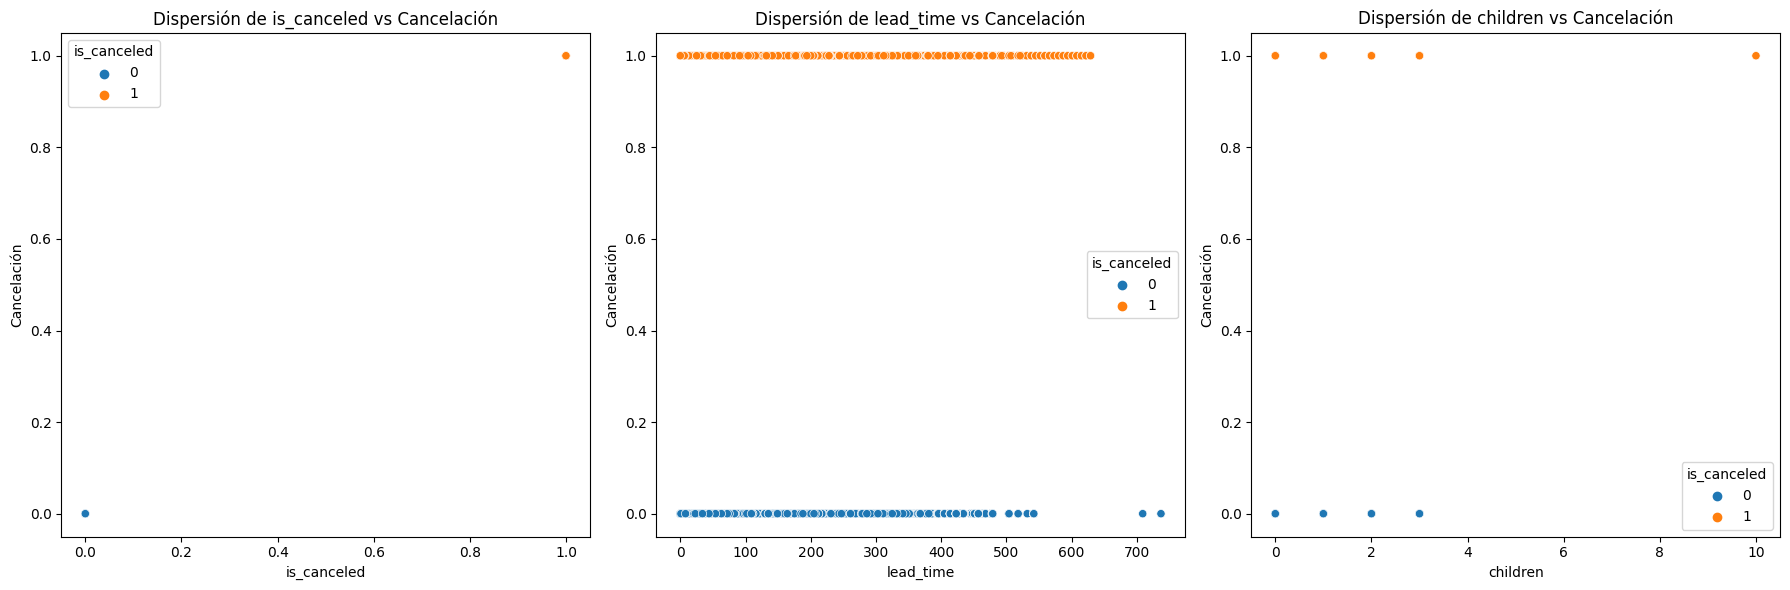

In [19]:
# Seleccionar las tres variables más importantes
top_3_features = X.columns[indices[:3]]

# Crear gráficos de dispersión para las tres variables más importantes
plt.figure(figsize=(18, 6))
for i, feature in enumerate(top_3_features, 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(x=df[feature], y=df['is_canceled'], hue=df['is_canceled'])
    plt.title(f'Dispersión de {feature} vs Cancelación')
    plt.xlabel(feature)
    plt.ylabel('Cancelación')
plt.tight_layout()
plt.show()

###### Árbol de Decisión

In [20]:
# Crear la consola Rich con tema claro
console = Console(style="bright_green")

# Entrenar el modelo
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Evaluar el modelo
y_pred_dt = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_report = classification_report(y_test, y_pred_dt)

# Crear tabla para mostrar la evaluación del modelo
result_table = Table(
    title="Evaluación del Modelo: Árbol de Decisión",
    show_header=True,
    header_style="bold white",
    style="white",
    border_style="white"
)

result_table.add_column("Métrica", justify="left", style="white")
result_table.add_column("Valor", justify="center", style="white")

# Añadir precisión a la tabla
result_table.add_row("Precisión", f"{dt_accuracy:.2f}")

# Crear un panel para el reporte de clasificación
report_panel = Panel(
    dt_report,
    title="Reporte de Clasificación",
    title_align="center",
    border_style="white"
)

# Imprimir resultados
console.print(result_table)
console.print(report_panel)

   Evaluación del    
  Modelo: Árbol de   
      Decisión       
┏━━━━━━━━━━━┳━━━━━━━┓
┃ Métrica   ┃ Valor ┃
┡━━━━━━━━━━━╇━━━━━━━┩
│ Precisión │ 1.00  │
└───────────┴───────┘

╭─────────────────────────────────────────── Reporte de Clasificación ────────────────────────────────────────────╮
│               precision    recall  f1-score   support                                                           │
│                                                                                                                 │
│            0       1.00      1.00      1.00     12676                                                           │
│            1       1.00      1.00      1.00      4798                                                           │
│                                                                                                                 │
│     accuracy                           1.00     17474                                                           │
│    macro avg       1.00      1.00      1.00     17474                                                           │
│ weighted avg       1.00      1.00      1.00     17474                                                           │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

###### Random Forest

In [21]:
# Crear la consola Rich con tema claro
console = Console(style="bright_magenta")

# Entrenar el modelo
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluar el modelo
y_pred_rf = rf_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_report = classification_report(y_test, y_pred_dt)

# Crear tabla para mostrar la evaluación del modelo
result_table = Table(
    title="Evaluación del Modelo: Random Forest",
    show_header=True,
    header_style="bold white",
    style="white",
    border_style="white"
)

result_table.add_column("Métrica", justify="left", style="white")
result_table.add_column("Valor", justify="center", style="white")

# Añadir precisión a la tabla
result_table.add_row("Precisión", f"{dt_accuracy:.2f}")

# Crear un panel para el reporte de clasificación
report_panel = Panel(
    dt_report,
    title="Reporte de Clasificación",
    title_align="center",
    border_style="white"
)

# Imprimir resultados
console.print(result_table)
console.print(report_panel)

   Evaluación del    
Modelo: Random Forest
┏━━━━━━━━━━━┳━━━━━━━┓
┃ Métrica   ┃ Valor ┃
┡━━━━━━━━━━━╇━━━━━━━┩
│ Precisión │ 1.00  │
└───────────┴───────┘

╭─────────────────────────────────────────── Reporte de Clasificación ────────────────────────────────────────────╮
│               precision    recall  f1-score   support                                                           │
│                                                                                                                 │
│            0       1.00      1.00      1.00     12676                                                           │
│            1       1.00      1.00      1.00      4798                                                           │
│                                                                                                                 │
│     accuracy                           1.00     17474                                                           │
│    macro avg       1.00      1.00      1.00     17474                                                           │
│ weighted avg       1.00      1.00      1.00     17474                                                           │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

###### Regresión Logística

In [22]:
# Crear la consola Rich con tema claro
#console = Console(style="bright_magenta")
console = Console(style="bright_cyan ")


# Entrenar el modelo
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluar el modelo
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_report = classification_report(y_test, y_pred_rf)

# Crear tabla para mostrar la evaluación del modelo
result_table = Table(
    title="Evaluación del Modelo: Random Forest",
    show_header=True,
    header_style="bold white",
    style="white",
    border_style="white"
)

result_table.add_column("Métrica", justify="left", style="white")
result_table.add_column("Valor", justify="center", style="white")

# Añadir precisión a la tabla
result_table.add_row("Precisión", f"{rf_accuracy:.2f}")

# Crear un panel para el reporte de clasificación
report_panel = Panel(
    rf_report,
    title="Reporte de Clasificación",
    title_align="center",
    border_style="white"
)

# Imprimir resultados
console.print(result_table)
console.print(report_panel)

   Evaluación del    
Modelo: Random Forest
┏━━━━━━━━━━━┳━━━━━━━┓
┃ Métrica   ┃ Valor ┃
┡━━━━━━━━━━━╇━━━━━━━┩
│ Precisión │ 1.00  │
└───────────┴───────┘

╭─────────────────────────────────────────── Reporte de Clasificación ────────────────────────────────────────────╮
│               precision    recall  f1-score   support                                                           │
│                                                                                                                 │
│            0       1.00      1.00      1.00     12676                                                           │
│            1       1.00      1.00      1.00      4798                                                           │
│                                                                                                                 │
│     accuracy                           1.00     17474                                                           │
│    macro avg       1.00      1.00      1.00     17474                                                           │
│ weighted avg       1.00      1.00      1.00     17474                                                           │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

# Pruebas

##### Entrenar el modelo 

Clasificacion utilizando el algoritmo de arbol de decisión

In [71]:
# Crear las variables X(predictoras) e y(objetivo)

new_features = ['is_canceled', 'lead_time', 'required_car_parking_spaces','total_of_special_requests']
X = df[new_features].drop(columns=['is_canceled'])  # Variables predictoras
y = df['is_canceled']  # Variable objetivo


In [54]:
X

,lead_time,required_car_parking_spaces,total_of_special_requests
0,342,0,0
1,737,0,0
2,7,0,0
3,13,0,0
4,14,0,1
...,...,...,...
87364,23,0,0
87365,102,0,2
87366,34,0,4
87367,109,0,0


In [55]:
y

0        0
1        0
2        0
3        0
4        0
        ..
87364    0
87365    0
87366    0
87367    0
87368    0
Name: is_canceled, Length: 87369, dtype: int64

###### Dividir los datos en conjuntos de entrenamiento y prueba

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30,random_state=42)

In [73]:
X_train.shape, X_test.shape

((61158, 3), (26211, 3))

In [74]:
y_train.shape , y_test.shape

((61158,), (26211,))

In [75]:
X_train.head()

,lead_time,required_car_parking_spaces,total_of_special_requests
53898,19,0,0
9621,158,0,0
11820,149,0,1
7719,28,0,0
13370,309,0,2


In [76]:
X_train.dtypes

lead_time                      int64
required_car_parking_spaces    int64
total_of_special_requests      int64
dtype: object

###### Entrenamiento de modelo de clasificacion con arbol de desicion

In [77]:
# Definir variables y crear las transoformaciones correspondientes

encoder  = ce.OrdinalEncoder(cols = [ 'lead_time', 'required_car_parking_spaces','total_of_special_requests'])

X_train = encoder.fit_transform(X_train)

X_test = encoder.fit_transform(X_test)



In [78]:
# Verificar la transformacion

X_train.head()

,lead_time,required_car_parking_spaces,total_of_special_requests
53898,1,1,1
9621,2,1,1
11820,3,1,2
7719,4,1,1
13370,5,1,3


In [81]:
# Importar arbol de desicion y crear el modelo

tree = DecisionTreeClassifier(max_depth=2,random_state=42)

In [82]:
# Entrenar el modelo

tree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=2, random_state=42)

###### Cálculos de las predicciones para posteriormente calcular la performance

In [83]:
# Predicciones para el conjunto de entrenamiento
y_train_pred_tree = tree.predict(X_train)

# Predicciones para el conjunto de prueba
y_test_pred_tree = tree.predict(X_test)



In [84]:
y_train_pred_tree

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [85]:
y_test_pred_tree

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

##### Evaluación del modelo

###### Calculo del performance

In [86]:
# Cálculo de accuracy del train

train_accuracy_tree = accuracy_score( y_train , y_train_pred_tree)

# Cálculo de accuracy del test

test_accuracy_tree = accuracy_score( y_test , y_test_pred_tree)

print('El accuracy en train es: ',train_accuracy_tree)
print('El accuracy en test es: ',test_accuracy_tree)

El accuracy en train es:  0.7243533143660682
El accuracy en test es:  0.7267559421616878


###### Verificamos le feature importance


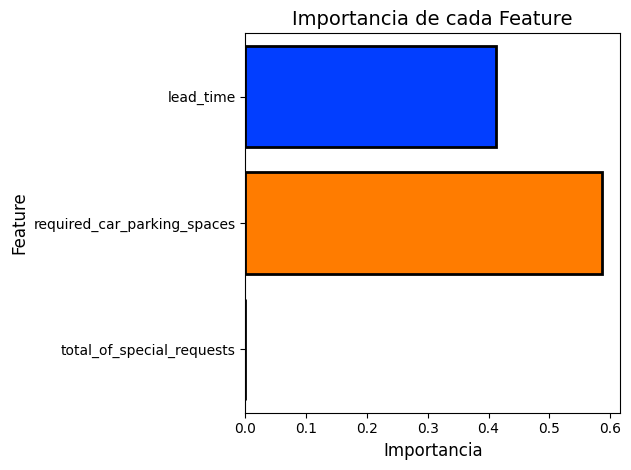

In [96]:
importances = tree.feature_importances_
columns = list(X.columns)

sns.barplot(x=importances, y=columns, palette='bright', saturation=2.0, edgecolor='black', linewidth=2)
plt.title('Importancia de cada Feature', fontsize=14)
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# -----------------------------------------

##### Entrenar el modelo 

Clasificacion utilizando el algoritmo de random forest

In [97]:
# Crear las variables X(predictoras) e y(objetivo)

new_features = ['is_canceled', 'lead_time', 'required_car_parking_spaces','total_of_special_requests']
X = df[new_features].drop(columns=['is_canceled'])  # Variables predictoras
y = df['is_canceled']  # Variable objetivo

###### Dividir los datos en conjuntos de entrenamiento y prueba

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30,random_state=42)

###### Entrenamiento de modelo de clasificacion con random forest

In [ ]:
# Definir variables y crear las transoformaciones correspondientes

# encoder  = ce.OrdinalEncoder(cols = [ 'lead_time', 'required_car_parking_spaces','total_of_special_requests'])

# X_train = encoder.fit_transform(X_train)

# X_test = encoder.fit_transform(X_test)

In [99]:
# Importar arbol de desicion y crear el modelo

random_forest = RandomForestClassifier(n_estimators=10,random_state=42)

In [101]:
# Entrenar el modelo

random_forest.fit(X_train,y_train)

RandomForestClassifier(n_estimators=10, random_state=42)

###### Cálculos de las predicciones para posteriormente calcular la performance

In [102]:
# Predicciones para el conjunto de entrenamiento
y_train_pred_random_forest = random_forest.predict(X_train)

# Predicciones para el conjunto de prueba
y_test_pred_random_forest = random_forest.predict(X_test)


##### Evaluación del modelo

###### Calculo del performance

In [103]:
# Cálculo de accuracy del train

train_accuracy_random_forest = accuracy_score( y_train , y_train_pred_random_forest)

# Cálculo de accuracy del test

test_accuracy_random_forest = accuracy_score( y_test , y_test_pred_random_forest)

print('El accuracy en train es: ',train_accuracy_random_forest)
print('El accuracy en test es: ',test_accuracy_random_forest)

El accuracy en train es:  0.7243533143660682
El accuracy en test es:  0.7267559421616878


###### Verificamos del feature importance

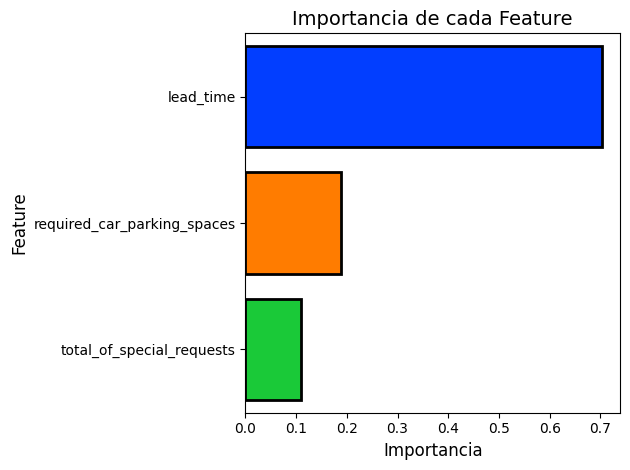

In [104]:
importances = random_forest.feature_importances_
columns = list(X.columns)

sns.barplot(x=importances, y=columns, palette='bright', saturation=2.0, edgecolor='black', linewidth=2)
plt.title('Importancia de cada Feature', fontsize=14)
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# -----------------------------------------

###### Dividir los datos en conjuntos de entrenamiento y prueba

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X[new_features], y, test_size=0.2, random_state=42)

###### Creación del modelo

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)

###### Entrenamiento

In [ ]:
dt_model.fit(X_train, y_train)

##### Evalucación del modelo

###### Cálculos de las predicciones para posteriormente calcular la performance

In [ ]:
# Calculo de Predicciones en train como en test

y_train_pred = dt_model.predict(X_train)

y_test_pred = dt_model.predict(X_test)

In [ ]:
# Cáclculo de las metricas

# Cálculo del acuracy en train
train_accuracy = accuracy_score(y_train, y_train_pred)

# Cálculo del acuracy en test
test_accuracy = accuracy_score(y_test, y_test_pred)

print('El accuracy en train es: ', train_accuracy)
print('El accuracy en test es: ', test_accuracy)

###### Verificar la feature  importance

In [ ]:
# Seleccionar las mejores variables
X = df[columnas_numericas]
y = df['is_canceled']

# Aplicar SelectKBest
selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X, y)

# Obtener los nombres de las variables seleccionadas
mask = selector.get_support()  # lista de booleanos
new_features = []  # La lista de las mejores características

for bool, feature in zip(mask, columnas_numericas):
    if bool:
        new_features.append(feature)

print(f"Las mejores variables para predecir cancelaciones son: {new_features}")

In [ ]:
# Entrenar el modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X[new_features], y)

# Obtener la importancia de las características
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Imprimir las variables más importantes
print("Variables más importantes para predecir cancelaciones:")
for f in range(len(new_features)):
    print(f"{new_features[indices[f]]}: {importances[indices[f]]}")

# Crear un DataFrame con las importancias
importance_df = pd.DataFrame({'Feature': [new_features[i] for i in indices], 'Importance': importances[indices]})

# Graficar la importancia de las características
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='bright', saturation=2.0, edgecolor='black', linewidth=2)
plt.title('Importancia de cada Feature')
plt.show()